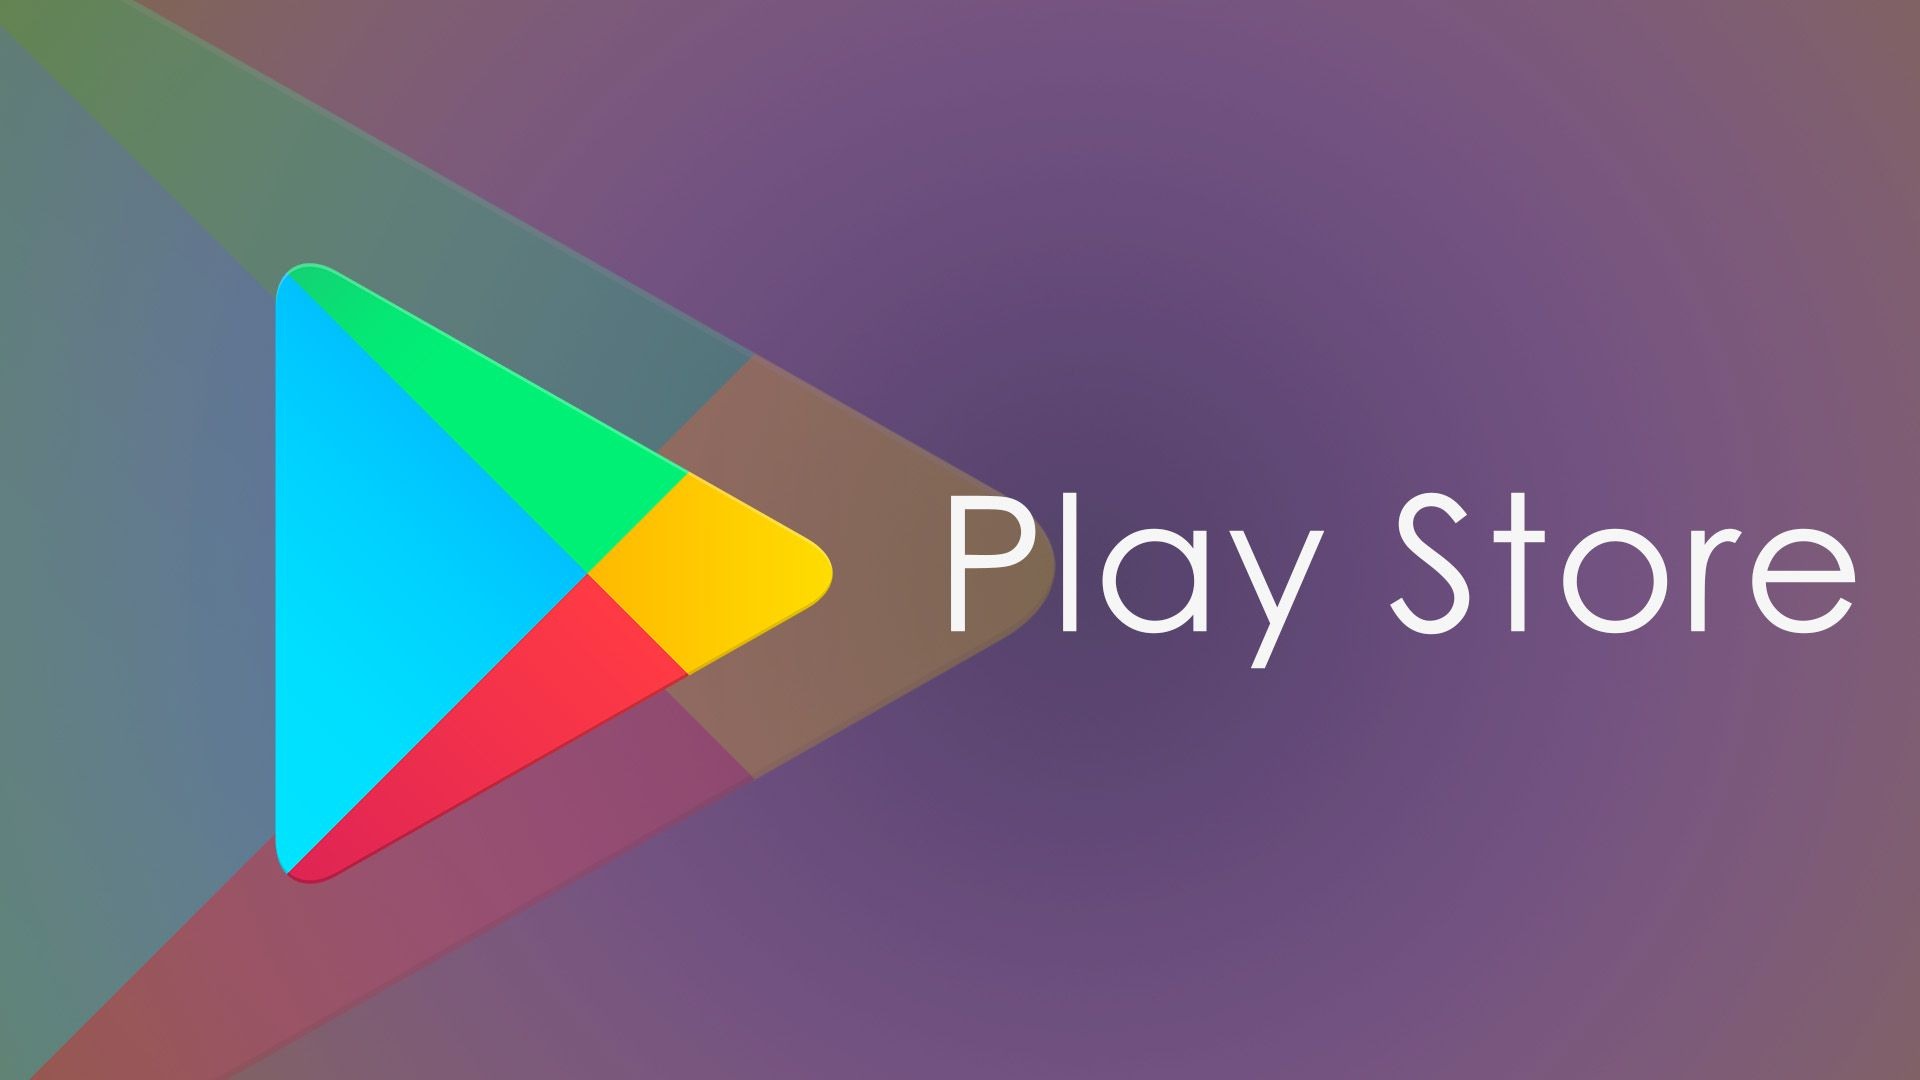

# Loading Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Read Data & Checking NA's


In [ ]:
app1=pd.read_csv("../input/playstore-analysis/googleplaystore.csv");app1.head()

In [ ]:
print(app1.dtypes,app1.isnull().sum())
app1.shape

In [ ]:
app1.dropna(inplace=True);print(app1.shape)


# Data Cleaning

### Variables seem to have incorrect type and inconsistent formatting,also Size column has sizes in Kb as well as Mb,Multiply the value by 1,000, if size is mentioned in Mb

In [ ]:
print(app1.Size.value_counts())

def change(Size):
    if 'M'in Size:
        x=Size[:-1]
        x=float(x)*1000
        return x

    elif 'k'in Size:
        x=Size[:-1]
        x=float(x)
        return x
    
    else: return None

    
app1.Size=app1.Size.map(change);app1.Size.value_counts()

    

In [ ]:
print(app1.Size.isnull().sum())
app1.Size.fillna(method='pad',inplace=True)
print(app1.Size.isnull().sum())

### Reviews is a numeric field that is loaded as a string field.Convert it to numeric 
### Installs field is currently stored as string and has values like 1,000,000+, remove ‘+’, ‘,’ from the field, convert it to integer 
### Price field is a string and has $ symbol. Remove ‘$’ sign, and convert it to numeric

In [ ]:
app1.Reviews=app1.Reviews.astype('float')

print(app1.Installs.value_counts()[:5])
app1.Installs=app1.Installs.map(lambda x:x.replace(',','').replace('+',''))
print(app1.Installs.value_counts()[:5])
app1.Installs=app1.Installs.astype('float')

print(app1.Price.value_counts()[:5])
app1.Price=app1.Price.map(lambda x:x.replace('$',''))
print(app1.Price.value_counts()[:5])
app1.Price=app1.Price.astype('float')

print(app1.dtypes)
                          

### * Average rating should be between 1 and 5 as only these values are allowed on the play store. Drop the rows that have a value outside this range.
 
### * Reviews should not be more than installs as only those who installed can review the app. If there are any such records, drop them.

### * For free apps (type = “Free”), the price should not be >0. Drop any such rows.

In [ ]:
print(len(app1[app1.Rating>5]))
print(len(app1[app1.Reviews>app1.Installs]))
print(len(app1[(app1.Type=='free')&(app1.Price>0)]))

app1=app1[app1.Reviews<app1.Installs].copy();print(app1.shape)

print(len(app1[app1.Price>200]))
app1=app1[app1.Price<200].copy();print(app1.shape)

print(len(app1[app1.Reviews>=2000000]))
app1=app1[app1.Reviews<=2000000].copy();print(app1.shape)

print(app1.Installs.quantile([.25,.50,.75,.90,.99]))
print(len(app1[app1.Installs>= 10000000]))
app1=app1[app1.Installs<=10000000].copy();print(app1.shape)

# Outlier Correction

### It seems from the histogram(below) the variables has some skewness and from boxplot it is evident that it has outliers too...Lets correct it by applying log 

In [ ]:
print(app1.hist(['Rating','Reviews','Size','Installs','Price'],figsize=(12,8),xlabelsize=12,ylabelsize=12))


In [ ]:
app1.boxplot(fontsize=15)


In [ ]:
app1.Reviews=app1.Reviews.apply(func=np.log1p)
app1.Installs=app1.Installs.apply(func=np.log1p)

app1.hist(column=['Reviews','Installs'])


# Bivariate analysis: 
 
### Let’s look at how the available predictors relate to the variable of interest, i.e., our target variable rating. Make scatter plots (for numeric features) and box plots (for character features) to assess the relations between rating and the other features.

In [ ]:
plt.figure(figsize=(11,8))
sns.set_style(style='whitegrid',)
sns.set(font_scale=1.2)
sns.scatterplot(app1.Price,app1.Rating,hue=app1.Rating)

plt.show()

### While there is not a very clean pattern, it does look that the higher priced apps have better rating. Although, there are not a lot of apps which are high priced, but the pattern is apparent.

In [ ]:
plt.figure(figsize=(11,8))
sns.scatterplot(app1.Size,app1.Rating,hue=app1.Rating)

### Again, not a very clean pattern, but it does look like heavier apps are better rated.

In [ ]:
plt.figure(figsize=(11,8))
sns.scatterplot(app1.Reviews,app1.Rating,hue=app1.Rating)

### No clear pattern. There are fewer low rated apps among the popular ones (maybe poor ones won’t get so popular), after a certain point, the rating does not depend on the popularity.

In [ ]:
plt.figure(figsize=(12,8.27))
sns.boxplot(app1['Content Rating'],app1.Rating)

### While the median rating for most others is similar, the rating for “Adults Only 18+” is the highest.

In [ ]:
plt.figure(figsize=(25,8.27))
sns.boxplot(app1.Category,app1.Rating)
plt.xticks(fontsize=18,rotation='vertical')
plt.yticks(fontsize=18)
plt.xlabel("Category",fontsize=20)
plt.ylabel("Rating",fontsize=20)

### Apps around Health & Fitness, Books and Reference, Events seem to have the highest median ratings.

# Deleting Unnecessary Variables

In [ ]:
app1.drop(["App", "Last Updated", "Current Ver", "Android Ver"], axis=1, inplace=True);print(app1.shape)
app1=pd.get_dummies(app1,drop_first=True);print(app1.columns)


# Linear Regresssion Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
linreg=LinearRegression()
from statsmodels.api import OLS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as ms

### Next, we split 70% of the data to the training set while 30% of the data to test set using below code.

In [ ]:
X=app1.iloc[:,1:]
y=app1.iloc[:,:1]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=1)
X_train.shape,X_test.shape

### Building Model & Predicting the Ratings, also checking the difference between the actual value and predicted value.

In [ ]:
Model=linreg.fit(X_train, y_train)
predict=linreg.predict(X_test)

y_test=np.array(y_test)
predict=np.array(predict)

a=pd.DataFrame({'Actual':y_test.flatten(),'Predicted':predict.flatten()});a.head(10)


### In Below figure we can observe here that the model has returned pretty good prediction results.

In [ ]:
fig=a.head(25)
fig.plot(kind='bar',figsize=(10,8))

# Model Summary

In [ ]:
results=OLS( y_train,X_train).fit()
results.summary()

In [ ]:
print('R2_Score=',r2_score(y_test,predict))
print('Root Mean Squared Error=',np.sqrt(ms(y_test,predict)))
print('Prediction Error Percentage is',round((0.50/np.mean(y_test))*100))

# Summary Interpretation

### * A large F-statistic will corresponds to a statistically significant p-value (p < 0.05). In the data, the F-statistic equals 3545. that leads to less P_Value which says that at least one of the predictor variables is significantly related to the outcome variable.

### * From the output above, the adjusted R2 is 0.986, meaning that the observed and the predicted outcome values are highly correlated, which is very good.

### * The prediction error RMSE (Root Mean Squared Error), representing the average difference between the observed known outcome values in the test data and the predicted outcome seems to be 0.50 which is very good thus represents the error rate of 12%



> #### Kindly Share your Comments for Improvements